In [35]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit import ClassicalRegister, QuantumRegister

In [36]:
import qiskit.quantum_info as qi

id_op = qi.Operator([[1,0],[0,1]])
x_op = qi.Operator([[0,1],[1,0]])

id_op

Operator([[1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]],
         input_dims=(2,), output_dims=(2,))

In [37]:
x_op

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))

In [65]:
nq_data = 3
nq_anc = 2
nq = nq_data + nq_anc

creg_data = ClassicalRegister(nq_data)
creg_anc = ClassicalRegister(nq_anc)
# creg = ClassicalRegister(nq)
# qreg = QuantumRegister(nq)
qreg_data = QuantumRegister(nq_data)
qreg_anc = QuantumRegister(nq_anc)

qc = QuantumCircuit(qreg_data, qreg_anc, creg_data, creg_anc)

qc.cx(0,1)
qc.cx(0,2)

qc.barrier(range(nq))

# qc.unitary(id_op, 0, label='bit-flip')
qc.unitary(x_op, qreg_data, label='bit-flip')
# qc.unitary(x_op, 0, label='bit-flip')
# qc.id(0, label='d')
# qc.x(0)

qc.barrier(range(nq))

qc.cx(0,3)
qc.cx(1,3)
qc.cx(0,4)
qc.cx(2,4)

qc.measure([3,4],[creg_anc[0],creg_anc[1]])

# |00> corresponds to classical binary 00
# |10> corresponds to q0 = |0> and q1 = |1> 
# : classical corresonds to 10 in binary, which is 2

# [NOTE] x(0) is required when q_ancilla_0 = 1, q_ancilla_1 = 1 
# => |11> in ancilla space => classical bits 11 in binary = 3
qc.x(0).c_if(creg_anc, 3) 
# [NOTE] x(1) is required when q_ancilla_0 = 1, q_ancilla_1 = 0
# => |01> in ancilla space => classical bits 01 in binary = 1
qc.x(1).c_if(creg_anc, 1)
qc.x(2).c_if(creg_anc, 2)

qc.barrier(range(nq))

qc.measure([0,1,2], [0,1,2])

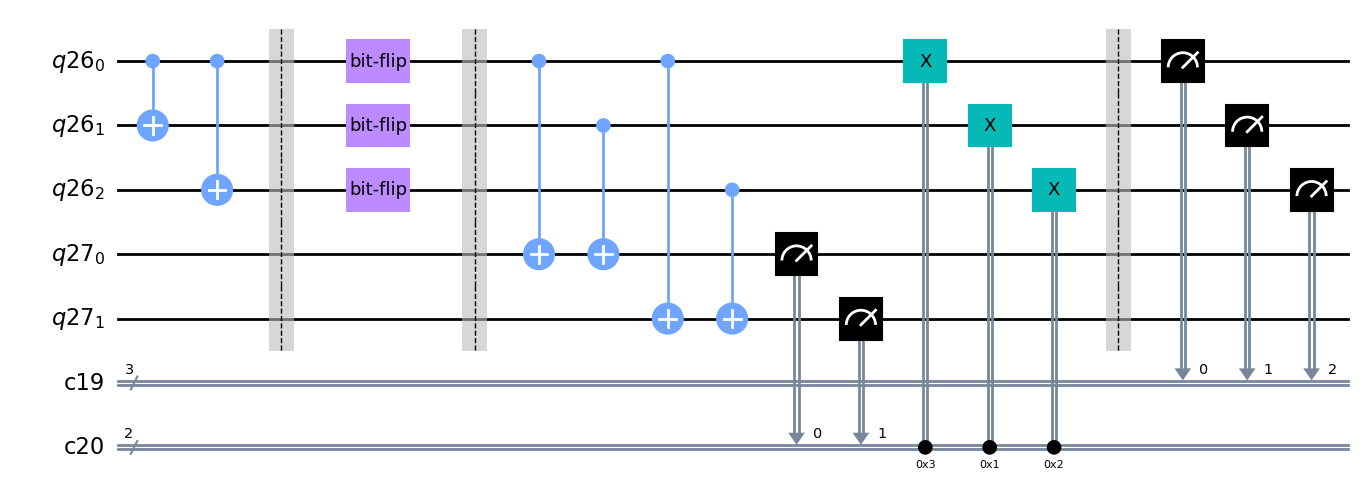

In [67]:
qc.draw('mpl')

In [68]:
p_err = 0.03 # 0.25 # 0.1
# error_x = pauli_error([('X', p_err), ('I', 1 - p_err)])
error_inv_x = pauli_error([('X', 1 - p_err), ('I', p_err)])

In [69]:
# print(error_x)

In [70]:
model_bit_flip = NoiseModel()
# model_bit_flip.add_all_qubit_quantum_error(error_x, 'bit-flip')
model_bit_flip.add_all_qubit_quantum_error(error_inv_x, 'bit-flip')
model_bit_flip.add_basis_gates(['unitary'])

# model_bit_flip.add_quantum_error(error_x, 'x', [1])

In [71]:
model_bit_flip.basis_gates

['cx', 'id', 'rz', 'sx', 'unitary']

In [72]:
print(model_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['bit-flip']
  All-qubits errors: ['bit-flip']


In [73]:
sim_noise = AerSimulator(noise_model=model_bit_flip)
qc_tnoise = transpile(qc, sim_noise)

In [74]:
qc_tnoise.draw()

░ ┌──────────┐ ░                           ┌───────┐ ┌────┐»
q26_0: ──■────■───░─┤ bit-flip ├─░───■────■──────────────────┤ Rz(π) ├─┤ √X ├»
       ┌─┴─┐  │   ░ ├──────────┤ ░   │    │                  └───╥───┘ └─╥──┘»
q26_1: ┤ X ├──┼───░─┤ bit-flip ├─░───┼────┼────■─────────────────╫───────╫───»
       └───┘┌─┴─┐ ░ ├──────────┤ ░   │    │    │                 ║       ║   »
q26_2: ─────┤ X ├─░─┤ bit-flip ├─░───┼────┼────┼────■────────────╫───────╫───»
            └───┘ ░ └──────────┘ ░ ┌─┴─┐  │  ┌─┴─┐  │  ┌─┐       ║       ║   »
q27_0: ───────────░──────────────░─┤ X ├──┼──┤ X ├──┼──┤M├───────╫───────╫───»
                  ░              ░ └───┘┌─┴─┐└───┘┌─┴─┐└╥┘┌─┐    ║       ║   »
q27_1: ───────────░──────────────░──────┤ X ├─────┤ X ├─╫─┤M├────╫───────╫───»
                  ░              ░      └───┘     └───┘ ║ └╥┘    ║       ║   »
c19: 3/═════════════════════════════════════════════════╬══╬═════╬═══════╬═══»
                                                        ║  ║  ┌──╨──┐ ┌──╨──┐»
c20: 2/═════════════════════════════════════════════════╩══╩══╡ 0x3 ╞═╡ 0x3 ╞»
                                                        0  1  └─────┘ └─────┘»
«       ┌────────┐ ┌────┐┌────────┐                                           »
«q26_0: ┤ Rz(2π) ├─┤ √X ├┤ Rz(3π) ├───────────────────────────────────────────»
«       └───╥────┘ └─╥──┘└───╥────┘┌───────┐ ┌────┐┌────────┐ ┌────┐┌────────┐»
«q26_1: ────╫────────╫───────╫─────┤ Rz(π) ├─┤ √X ├┤ Rz(2π) ├─┤ √X ├┤ Rz(3π) ├»
«           ║        ║       ║     └───╥───┘ └─╥──┘└───╥────┘ └─╥──┘└───╥────┘»
«q26_2: ────╫────────╫───────╫─────────╫───────╫───────╫────────╫───────╫─────»
«           ║        ║       ║         ║       ║       ║        ║       ║     »
«q27_0: ────╫────────╫───────╫─────────╫───────╫───────╫────────╫───────╫─────»
«           ║        ║       ║         ║       ║       ║        ║       ║     »
«q27_1: ────╫────────╫───────╫─────────╫───────╫───────╫────────╫───────╫─────»
«           ║        ║       ║         ║       ║       ║        ║       ║     »
«c19: 3/════╬════════╬═══════╬═════════╬═══════╬═══════╬════════╬═══════╬═════»
«        ┌──╨──┐  ┌──╨──┐ ┌──╨──┐   ┌──╨──┐ ┌──╨──┐ ┌──╨──┐  ┌──╨──┐ ┌──╨──┐  »
«c20: 2/═╡ 0x3 ╞══╡ 0x3 ╞═╡ 0x3 ╞═══╡ 0x1 ╞═╡ 0x1 ╞═╡ 0x1 ╞══╡ 0x1 ╞═╡ 0x1 ╞══»
«        └─────┘  └─────┘ └─────┘   └─────┘ └─────┘ └─────┘  └─────┘ └─────┘  »
«                                                   ░ ┌─┐      
«q26_0: ────────────────────────────────────────────░─┤M├──────
«                                                   ░ └╥┘┌─┐   
«q26_1: ────────────────────────────────────────────░──╫─┤M├───
«       ┌───────┐ ┌────┐┌────────┐ ┌────┐┌────────┐ ░  ║ └╥┘┌─┐
«q26_2: ┤ Rz(π) ├─┤ √X ├┤ Rz(2π) ├─┤ √X ├┤ Rz(3π) ├─░──╫──╫─┤M├
«       └───╥───┘ └─╥──┘└───╥────┘ └─╥──┘└───╥────┘ ░  ║  ║ └╥┘
«q27_0: ────╫───────╫───────╫────────╫───────╫──────░──╫──╫──╫─
«           ║       ║       ║        ║       ║      ░  ║  ║  ║ 
«q27_1: ────╫───────╫───────╫────────╫───────╫──────░──╫──╫──╫─
«           ║       ║       ║        ║       ║      ░  ║  ║  ║ 
«c19: 3/════╬═══════╬═══════╬════════╬═══════╬═════════╩══╩══╩═
«        ┌──╨──┐ ┌──╨──┐ ┌──╨──┐  ┌──╨──┐ ┌──╨──┐      0  1  2 
«c20: 2/═╡ 0x2 ╞═╡ 0x2 ╞═╡ 0x2 ╞══╡ 0x2 ╞═╡ 0x2 ╞══════════════
«        └─────┘ └─────┘ └─────┘  └─────┘ └─────┘

In [75]:
'unitary' in AerSimulator().configuration().basis_gates

True

In [76]:
n_shots = 1024

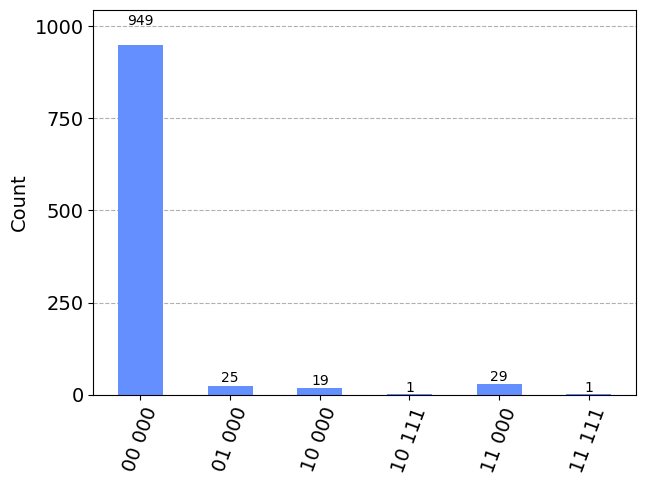

In [77]:
result_bit_flip = sim_noise.run(qc_tnoise, shots=n_shots).result()
counts_bit_flip = result_bit_flip.get_counts(0)

plot_histogram(counts_bit_flip)

In [15]:
# N_shots = result_bit_flip.results[0].shots

In [16]:
proportions = {
    k: counts_bit_flip[k] / n_shots 
    for k, v in counts_bit_flip.items()
}

In [17]:
proportions

{'11 000': 1.0}

---

In [18]:
nq = 1
qc = QuantumCircuit(nq)
qc.x(0)
qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

In [19]:
p_err = 0.03 # 0.25 # 0.1
error_x = pauli_error([('X', p_err), ('I', 1 - p_err)])

In [20]:
print(error_x)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.03, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.97, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [21]:
model_bit_flip = NoiseModel()
model_bit_flip.add_all_qubit_quantum_error(error_x, 'x')

In [22]:
sim_noise = AerSimulator(noise_model=model_bit_flip)
qc_tnoise = transpile(qc, sim_noise)

In [23]:
qc_tnoise.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

In [24]:
n_shots = 1024

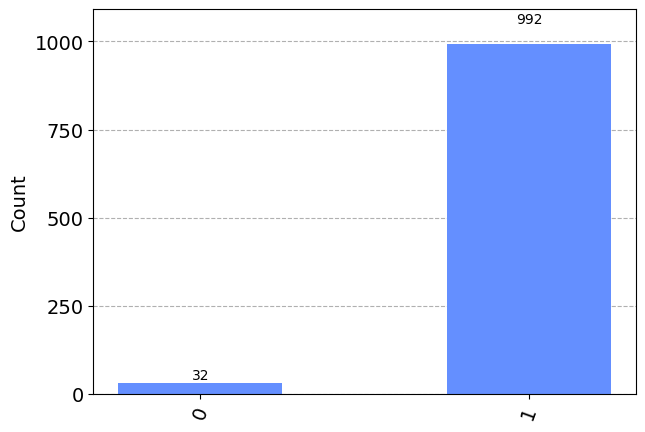

In [25]:
result_bit_flip = sim_noise.run(qc_tnoise, shots=n_shots).result()
counts_bit_flip = result_bit_flip.get_counts(0)

plot_histogram(counts_bit_flip)

In [36]:
# N_shots = result_bit_flip.results[0].shots

In [37]:
proportions = {
    k: counts_bit_flip[k] / n_shots 
    for k, v in counts_bit_flip.items()
}

In [28]:
proportions

{'1': 0.962890625, '0': 0.037109375}

In [38]:
proportions

{'1': 0.9697265625, '0': 0.0302734375}

In [33]:
proportions

{'1': 0.9638671875, '0': 0.0361328125}

In [39]:
proportions['0']

0.0302734375

In [34]:
p_err

0.03

In [27]:
sum(proportions.values())

1.0

---

In [2]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

In [3]:
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


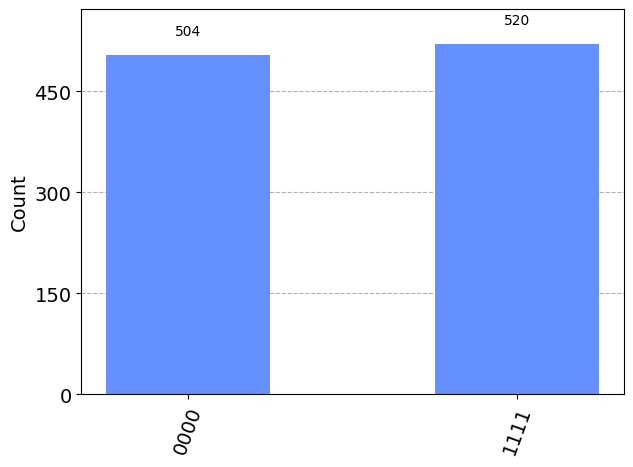

In [9]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

In [11]:
sim_ideal.configuration().basis_gates

['ccx',
 'cp',
 'cswap',
 'csx',
 'cu',
 'cu1',
 'cu2',
 'cu3',
 'cx',
 'cy',
 'cz',
 'delay',
 'diagonal',
 'ecr',
 'h',
 'id',
 'initialize',
 'mcp',
 'mcphase',
 'mcr',
 'mcrx',
 'mcry',
 'mcrz',
 'mcswap',
 'mcsx',
 'mcu',
 'mcu1',
 'mcu2',
 'mcu3',
 'mcx',
 'mcx_gray',
 'mcy',
 'mcz',
 'multiplexer',
 'p',
 'pauli',
 'r',
 'roerror',
 'rx',
 'rxx',
 'ry',
 'ryy',
 'rz',
 'rzx',
 'rzz',
 's',
 'sdg',
 'swap',
 'sx',
 'sxdg',
 't',
 'tdg',
 'u',
 'u1',
 'u2',
 'u3',
 'unitary',
 'x',
 'y',
 'z',
 'break_loop',
 'continue_loop',
 'for_loop',
 'if_else',
 'kraus',
 'qerror_loc',
 'quantum_channel',
 'roerror',
 'save_amplitudes',
 'save_amplitudes_sq',
 'save_clifford',
 'save_density_matrix',
 'save_expval',
 'save_expval_var',
 'save_matrix_product_state',
 'save_probabilities',
 'save_probabilities_dict',
 'save_stabilizer',
 'save_state',
 'save_statevector',
 'save_statevector_dict',
 'save_superop',
 'save_unitary',
 'set_density_matrix',
 'set_matrix_product_state',
 'set_stabi

In [56]:
p_err = 0.25 # 0.1 # 0.03
error_x = pauli_error([('X', p_err), ('I', 1 - p_err)])

In [57]:
model_bit_flip = NoiseModel()
model_bit_flip.add_all_qubit_quantum_error(error_x, 'h')

In [58]:
print(model_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['h']
  All-qubits errors: ['h']


In [59]:
from qiskit import transpile

In [60]:
sim_noise = AerSimulator(noise_model=model_bit_flip)

circ_tnoise = transpile(circ, sim_noise)

In [65]:
result_bit_flip = sim_noise.run(circ_tnoise).result()

counts_bit_flip = result_bit_flip.get_counts(0)

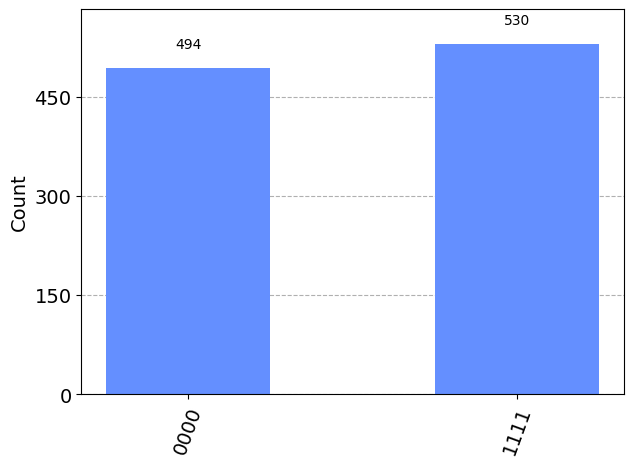

In [66]:
plot_histogram(counts_bit_flip)